In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from phylotorch.coalescent import ConstantCoalescent

torch.manual_seed(0)
np.random.seed(0)

In [3]:
def simulate(theta, taxon_count):
    intervals = []
    count = taxon_count
    lineages = []
    for i in range(taxon_count-1):
        intervals.append(np.random.exponential(1.0/(count*(count-1)/2/theta)))
        lineages.append(count)
        count -= 1
    return {'intervals': intervals, 'heights': list(np.cumsum(intervals)), 'lineages': lineages}

In [4]:
taxon_count = 50
theta = 4
sim = simulate(theta, taxon_count)
sampling_times = Variable(torch.tensor([0.0]*taxon_count), requires_grad=False)
heights = Variable(torch.tensor(sim['heights']), requires_grad=False)
#print([0]*taxon_count + sim['intervals'])
#print([0]*taxon_count + [1]*(taxon_count-1) )

In [5]:
coalescent = ConstantCoalescent(sampling_times)

optimizer = torch.optim.Adam(coalescent.parameters(),lr=0.1)
elbo_hist = []
mu_grads = []
sigma_grads = []

for i in range(20000):
    loss = -coalescent.elbo(heights)
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    mu_grads.append(coalescent.theta_mu.grad.item())
    sigma_grads.append(coalescent.theta_sigma.grad.item()**2)
    optimizer.step()
    if i % 2500 ==0:
        print(coalescent.theta_mu.item(), coalescent.theta_sigma.item()**2, -loss.item())

1.6409960985183716 0.1547862929794599 -217.75086975097656
1.554230809211731 4.321022707667964 -119.54512786865234
1.4723479747772217 3.4479978345398763 -121.32579040527344
1.4595921039581299 4.586724809547604 -119.33396911621094
1.4694253206253052 3.1532860912812453 -118.96878051757812
1.7058663368225098 3.887635961795141 -117.71651458740234
1.367505669593811 3.2273594504789713 -118.74745178222656
1.5281728506088257 5.2637778459029505 -119.68598175048828


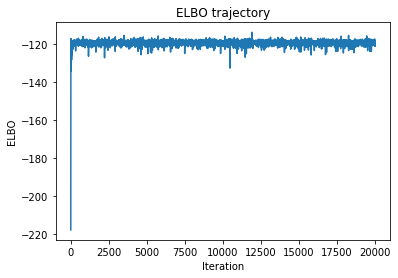

In [6]:
plt.plot(elbo_hist)
plt.title('ELBO trajectory')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.show()

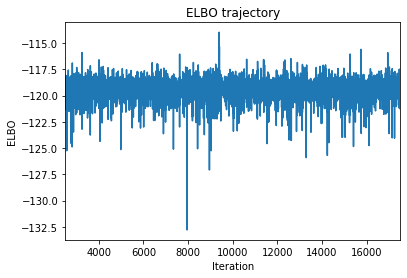

In [7]:
plt.plot(elbo_hist[2500:])
plt.title('ELBO trajectory')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.xlim([2500, len(elbo_hist)-2500])
plt.show()

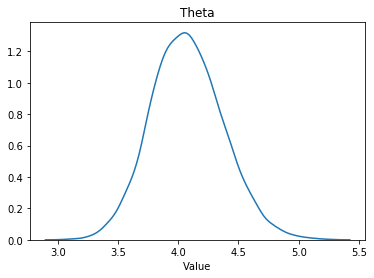

In [8]:
m = torch.distributions.Normal(coalescent.theta_mu, coalescent.theta_sigma.exp())
x = m.sample((10000,))
x = x.numpy().flatten()
sns.kdeplot(np.exp(x))
plt.xlabel('Value')
plt.title('Theta')
plt.show()

In [9]:
np.mean(np.exp(x))

4.0749474

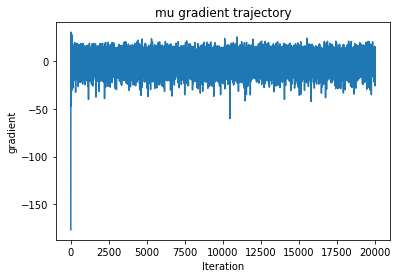

In [10]:
plt.plot(mu_grads)
plt.title('mu gradient trajectory')
plt.xlabel('Iteration')
plt.ylabel('gradient')
plt.show()

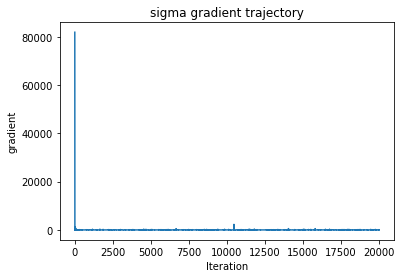

In [11]:
plt.plot(sigma_grads)
plt.title('sigma gradient trajectory')
plt.xlabel('Iteration')
plt.ylabel('gradient')
plt.show()